In [1]:
################################################################################################################################
#
# LSTM - JANSEN - FRACDIFF - STANDARD - DAILY
#
################################################################################################################################

#-------------------------------------------------------------------------------------------------------------------------------
# Test RMSE: 3428.41
#-------------------------------------------------------------------------------------------------------------------------------

#===============================================================================================================================
# ENVIRONMENT: LIBRARIES, SETTINGS
#===============================================================================================================================
#pip install pandas-datareader

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd
import pandas_datareader.data as web
import sklearn
import sklearn.preprocessing
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import spearmanr

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Activation
from tensorflow import keras

In [2]:
#===============================================================================================================================
# ENVIRONMENT: HARDWARE
#===============================================================================================================================
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using CPU


In [3]:
#===============================================================================================================================
# ENVIRONMENT: CONFIG
#===============================================================================================================================
sns.set_style('whitegrid')
np.random.seed(42)

In [4]:
#===============================================================================================================================
# DATA: INPUT/OUTPUT
#===============================================================================================================================
input_path = Path('Data', 'Input')
results_path = Path('Data\Output', 'LSTM-Jansen-FracDiff-Standard')
if not results_path.exists():
    results_path.mkdir(parents=True)

In [5]:
#===============================================================================================================================
# DATA: SETTINGS
#===============================================================================================================================
seriesId='IBOV-FracDiff'
#ESCALA = 'standard'
#EPOCAS = 100
#LOTE = 50
#NEURONS = 32
window_size=21

In [6]:
#===============================================================================================================================
# DATA: READ - FFD
#===============================================================================================================================
df = pd.read_csv('Data/Input/'+seriesId+'.csv')
#df['Date']= pd.to_datetime(df['Date'], format='%d/%m/%Y')
df.set_index('Date', inplace=True)
df

,Close
Date,
2001-10-18,1352.109469
2001-10-19,1738.220882
2001-10-22,2036.189415
2001-10-23,1833.354429
2001-10-24,1661.228961
...,...
2023-12-21,28560.747482
2023-12-22,28708.794508
2023-12-26,29129.784786


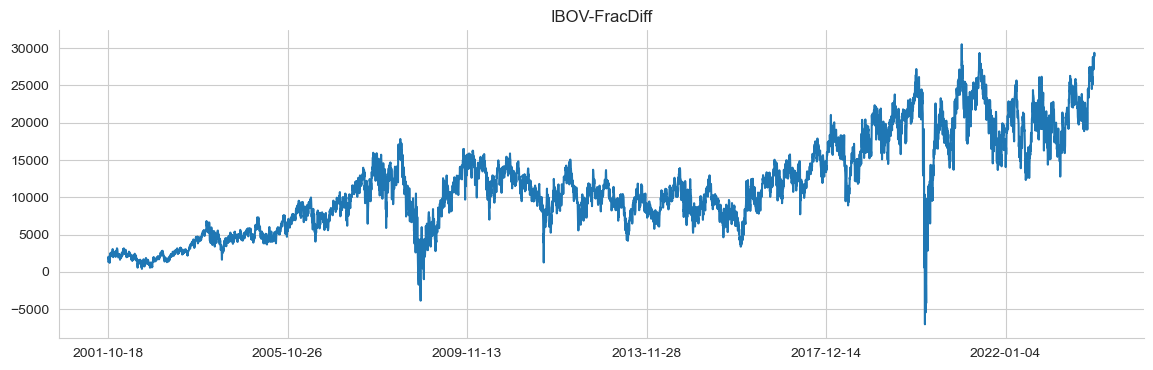

In [7]:
#===============================================================================================================================
# DATA: PLOT
#===============================================================================================================================
ax = df.plot(title=seriesId, legend=False, figsize=(14, 4), rot=0)
ax.set_xlabel('')
sns.despine()

In [8]:
#===============================================================================================================================
# DATA: SCALE - STANDARD - TRAIN
#===============================================================================================================================
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_scaled = pd.Series(scaler.fit_transform(df[:'2023']).squeeze(), index=df[:'2023'].index)
#print(df_scaled.describe())
df_scaled

Date
2001-10-18   -1.615850
2001-10-19   -1.551646
2001-10-22   -1.502099
2001-10-23   -1.535827
2001-10-24   -1.564449
                ...   
2022-12-23    1.649745
2022-12-26    1.388729
2022-12-27    1.361385
2022-12-28    1.635035
2022-12-29    1.478460
Length: 5249, dtype: float64

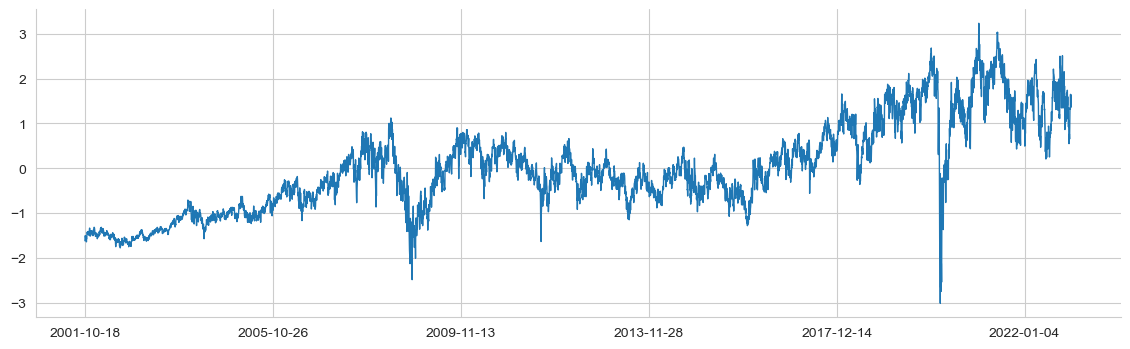

In [9]:
#===============================================================================================================================
# DATA: PLOT
#===============================================================================================================================
ax = df_scaled.plot(lw=1, figsize=(14, 4), rot=0)
ax.set_xlabel('')
sns.despine()

In [10]:
#===============================================================================================================================
# DATA: SCALE - STANDARD - TEST
#===============================================================================================================================
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#df_scaledtest = pd.Series(scaler.fit_transform(df['2023':]).squeeze(), index=df['2023':].index)
df_scaledtest = pd.Series(scaler.transform(df['2022-12-01':]).squeeze(), index=df['2022-12-01':].index)
#print(df_scaledtest.describe())
df_scaledtest

Date
2022-12-01    1.397941
2022-12-02    1.596177
2022-12-05    1.141625
2022-12-06    1.363595
2022-12-07    1.176398
                ...   
2023-12-21    2.908491
2023-12-22    2.933109
2023-12-26    3.003112
2023-12-27    3.045274
2023-12-28    2.977493
Length: 269, dtype: float64

In [11]:
#===============================================================================================================================
# DATA PREP: RECURRENT SEQUENCES - FUNCTION
#===============================================================================================================================
def create_univariate_rnn_data(data, window_size):
    n = len(data)
    y = data[window_size:]
    #y = data[window_size-1:]
    data = data.values.reshape(-1, 1) # make 2D
    X = np.hstack(tuple([data[i: n-j, :] for i, j in enumerate(range(window_size, 0, -1))]))
    #X = np.hstack(tuple([data[i: n-j+1, :] for i, j in enumerate(range(window_size, 0, -1))]))
    return pd.DataFrame(X, index=y.index), y

In [12]:
#===============================================================================================================================
# DATA PREP: RECURRENT SEQUENCES - RUN
#===============================================================================================================================
X, y = create_univariate_rnn_data(df_scaled, window_size=window_size)
X


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
Date,,,,,,,,,,,,,,,,,,,,,
2001-11-20,-1.615850,-1.551646,-1.502099,-1.535827,-1.564449,-1.519245,-1.520507,-1.594356,-1.639973,-1.564833,...,-1.440261,-1.430964,-1.420029,-1.449362,-1.427276,-1.467497,-1.409483,-1.441868,-1.436404,-1.425283
2001-11-21,-1.551646,-1.502099,-1.535827,-1.564449,-1.519245,-1.520507,-1.594356,-1.639973,-1.564833,-1.567640,...,-1.430964,-1.420029,-1.449362,-1.427276,-1.467497,-1.409483,-1.441868,-1.436404,-1.425283,-1.491730
2001-11-22,-1.502099,-1.535827,-1.564449,-1.519245,-1.520507,-1.594356,-1.639973,-1.564833,-1.567640,-1.440261,...,-1.420029,-1.449362,-1.427276,-1.467497,-1.409483,-1.441868,-1.436404,-1.425283,-1.491730,-1.456217
2001-11-23,-1.535827,-1.564449,-1.519245,-1.520507,-1.594356,-1.639973,-1.564833,-1.567640,-1.440261,-1.430964,...,-1.449362,-1.427276,-1.467497,-1.409483,-1.441868,-1.436404,-1.425283,-1.491730,-1.456217,-1.423252
2001-11-26,-1.564449,-1.519245,-1.520507,-1.594356,-1.639973,-1.564833,-1.567640,-1.440261,-1.430964,-1.420029,...,-1.427276,-1.467497,-1.409483,-1.441868,-1.436404,-1.425283,-1.491730,-1.456217,-1.423252,-1.367412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,1.677696,1.099559,1.154129,1.545731,1.740828,1.397941,1.596177,1.141625,1.363595,1.176398,...,1.068170,0.737605,0.550361,0.710112,0.761622,0.653304,1.032346,1.344994,1.350258,1.318740
2022-12-26,1.099559,1.154129,1.545731,1.740828,1.397941,1.596177,1.141625,1.363595,1.176398,0.925705,...,0.737605,0.550361,0.710112,0.761622,0.653304,1.032346,1.344994,1.350258,1.318740,1.649745
2022-12-27,1.154129,1.545731,1.740828,1.397941,1.596177,1.141625,1.363595,1.176398,0.925705,1.068170,...,0.550361,0.710112,0.761622,0.653304,1.032346,1.344994,1.350258,1.318740,1.649745,1.388729


In [13]:
#===============================================================================================================================
# DATA PREP: SPLIT
#===============================================================================================================================
X_train = X[:'2023'].values.reshape(-1, window_size, 1)
y_train = y[:'2023']

In [14]:
#===============================================================================================================================
# DATA PREP: RECURRENT SEQUENCES - RUN - TEST
#===============================================================================================================================
Xtest, ytest = create_univariate_rnn_data(df_scaledtest, window_size=window_size)
Xtest

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-02,1.397941,1.596177,1.141625,1.363595,1.176398,0.925705,1.068170,0.737605,0.550361,0.710112,...,0.653304,1.032346,1.344994,1.350258,1.318740,1.649745,1.388729,1.361385,1.635035,1.478460
2023-01-03,1.596177,1.141625,1.363595,1.176398,0.925705,1.068170,0.737605,0.550361,0.710112,0.761622,...,1.032346,1.344994,1.350258,1.318740,1.649745,1.388729,1.361385,1.635035,1.478460,0.911130
2023-01-04,1.141625,1.363595,1.176398,0.925705,1.068170,0.737605,0.550361,0.710112,0.761622,0.653304,...,1.344994,1.350258,1.318740,1.649745,1.388729,1.361385,1.635035,1.478460,0.911130,0.672203
2023-01-05,1.363595,1.176398,0.925705,1.068170,0.737605,0.550361,0.710112,0.761622,0.653304,1.032346,...,1.350258,1.318740,1.649745,1.388729,1.361385,1.635035,1.478460,0.911130,0.672203,1.002018
2023-01-06,1.176398,0.925705,1.068170,0.737605,0.550361,0.710112,0.761622,0.653304,1.032346,1.344994,...,1.318740,1.649745,1.388729,1.361385,1.635035,1.478460,0.911130,0.672203,1.002018,1.395795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-21,2.609600,2.649039,2.416593,2.460314,2.574231,2.461954,2.643237,2.721464,2.423687,2.460306,...,2.343461,2.516462,2.437108,2.336588,2.853947,2.953150,2.736092,2.855067,2.918308,2.675718
2023-12-22,2.649039,2.416593,2.460314,2.574231,2.461954,2.643237,2.721464,2.423687,2.460306,2.237358,...,2.516462,2.437108,2.336588,2.853947,2.953150,2.736092,2.855067,2.918308,2.675718,2.908491
2023-12-26,2.416593,2.460314,2.574231,2.461954,2.643237,2.721464,2.423687,2.460306,2.237358,2.343461,...,2.437108,2.336588,2.853947,2.953150,2.736092,2.855067,2.918308,2.675718,2.908491,2.933109


In [15]:
#===============================================================================================================================
# DATA PREP: RECURRENT SEQUENCES - TEST
#===============================================================================================================================
X_test = Xtest['2023':].values.reshape(-1, window_size, 1)
y_test = ytest['2023':]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(5228, 21, 1) (5228,) (248, 21, 1) (248,)


In [16]:
#===============================================================================================================================
# DATA PREP: OBS, WINDOWS, FEATURES
#===============================================================================================================================
n_obs, window_size, n_features = X_train.shape
n_obs, window_size, n_features

(5228, 21, 1)

In [17]:
#===============================================================================================================================
# MODEL: LSTM
#===============================================================================================================================
rnn = Sequential([
    LSTM(units=10, input_shape=(window_size, n_features), name='LSTM'),
    Dense(1, name='Output')
])

rnn.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM (LSTM)                 (None, 10)                480       
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 491 (1.92 KB)
Trainable params: 491 (1.92 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
#===============================================================================================================================
# MODEL: CONFIG
#===============================================================================================================================
optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, weight_decay=0.0)

rnn.compile(loss='mean_squared_error', optimizer=optimizer)

rnn_path = (results_path / 'LSTM-Jansen-FracDiff-Standard-Daily-rnn.h5').as_posix()
checkpointer = ModelCheckpoint(filepath=rnn_path, verbose=1, monitor='val_loss', save_best_only=True)

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

In [19]:
#===============================================================================================================================
# MODEL: TRAIN
#===============================================================================================================================
lstm_training = rnn.fit(X_train, y_train, epochs=150, batch_size=20, shuffle=True, 
                        validation_data=(X_test, y_test), 
                        callbacks=[early_stopping, checkpointer],verbose=1)

Epoch 1/150

259/262 [============================>.] - ETA: 0s - loss: 0.2241
Epoch 1: val_loss improved from inf to 0.12683, saving model to Data/Output/LSTM-Jansen-FracDiff-Standard\LSTM-Jansen-FracDiff-Standard-Daily-rnn.h5
262/262 [==============================] - 10s 15ms/step - loss: 0.2225 - val_loss: 0.1268
Epoch 2/150
257/262 [============================>.] - ETA: 0s - loss: 0.0446
Epoch 2: val_loss improved from 0.12683 to 0.07022, saving model to Data/Output/LSTM-Jansen-FracDiff-Standard\LSTM-Jansen-FracDiff-Standard-Daily-rnn.h5
262/262 [==============================] - 3s 11ms/step - loss: 0.0443 - val_loss: 0.0702
Epoch 3/150
262/262 [==============================] - ETA: 0s - loss: 0.0380
Epoch 3: val_loss improved from 0.07022 to 0.05962, saving model to Data/Output/LSTM-Jansen-FracDiff-Standard\LSTM-Jansen-FracDiff-Standard-Daily-rnn.h5
262/262 [==============================] - 3s 12ms/step - loss: 0.0380 - val_loss: 0.0596
Epoch 4/150
261/262 [==================

262/262 [==============================] - 3s 12ms/step - loss: 0.0295 - val_loss: 0.0464
Epoch 32/150
261/262 [============================>.] - ETA: 0s - loss: 0.0295
Epoch 32: val_loss did not improve from 0.04205
262/262 [==============================] - 3s 11ms/step - loss: 0.0295 - val_loss: 0.0428
Epoch 33/150
260/262 [============================>.] - ETA: 0s - loss: 0.0294
Epoch 33: val_loss did not improve from 0.04205
262/262 [==============================] - 3s 11ms/step - loss: 0.0293 - val_loss: 0.0424
Epoch 34/150
260/262 [============================>.] - ETA: 0s - loss: 0.0292
Epoch 34: val_loss did not improve from 0.04205
262/262 [==============================] - 3s 13ms/step - loss: 0.0294 - val_loss: 0.0423
Epoch 35/150
261/262 [============================>.] - ETA: 0s - loss: 0.0293
Epoch 35: val_loss did not improve from 0.04205
262/262 [==============================] - 3s 13ms/step - loss: 0.0293 - val_loss: 0.0421
Epoch 36/150
258/262 [====================

262/262 [==============================] - 3s 11ms/step - loss: 0.0284 - val_loss: 0.0414
Epoch 68/150
258/262 [============================>.] - ETA: 0s - loss: 0.0284
Epoch 68: val_loss did not improve from 0.04135
262/262 [==============================] - 3s 11ms/step - loss: 0.0285 - val_loss: 0.0430
Epoch 69/150
259/262 [============================>.] - ETA: 0s - loss: 0.0284
Epoch 69: val_loss improved from 0.04135 to 0.04131, saving model to Data/Output/LSTM-Jansen-FracDiff-Standard\LSTM-Jansen-FracDiff-Standard-Daily-rnn.h5
262/262 [==============================] - 3s 11ms/step - loss: 0.0285 - val_loss: 0.0413
Epoch 70/150
257/262 [============================>.] - ETA: 0s - loss: 0.0284
Epoch 70: val_loss did not improve from 0.04131
262/262 [==============================] - 3s 11ms/step - loss: 0.0285 - val_loss: 0.0433
Epoch 71/150
259/262 [============================>.] - ETA: 0s - loss: 0.0286
Epoch 71: val_loss did not improve from 0.04131
262/262 [=================

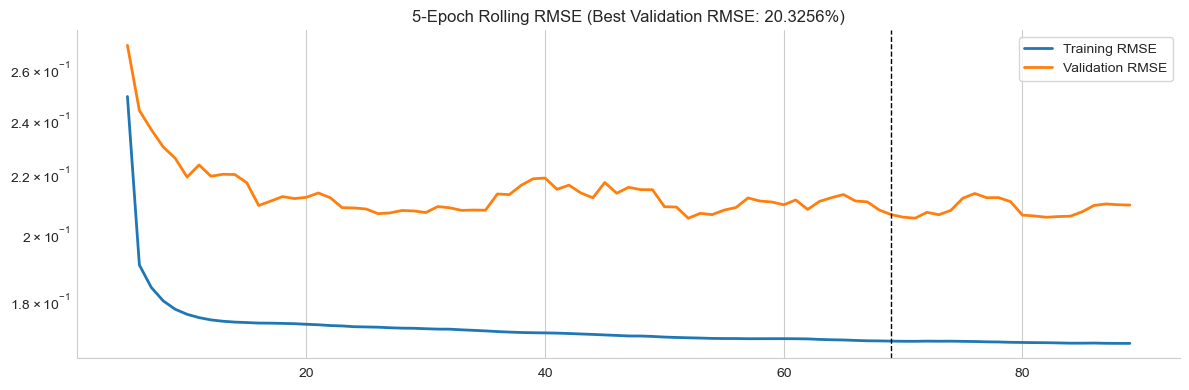

In [20]:
#===============================================================================================================================
# RESULTS - PERFORMANCE vs EPOCHS - TRAIN, VALIDATION
#===============================================================================================================================
fig, ax = plt.subplots(figsize=(12, 4))

loss_history = pd.DataFrame(lstm_training.history).pow(.5)
loss_history.index += 1
best_rmse = loss_history.val_loss.min()

best_epoch = loss_history.val_loss.idxmin()

title = f'5-Epoch Rolling RMSE (Best Validation RMSE: {best_rmse:.4%})'
loss_history.columns=['Training RMSE', 'Validation RMSE']
loss_history.rolling(5).mean().plot(logy=True, lw=2, title=title, ax=ax)

ax.axvline(best_epoch, ls='--', lw=1, c='k')

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'rnn_error', dpi=300);

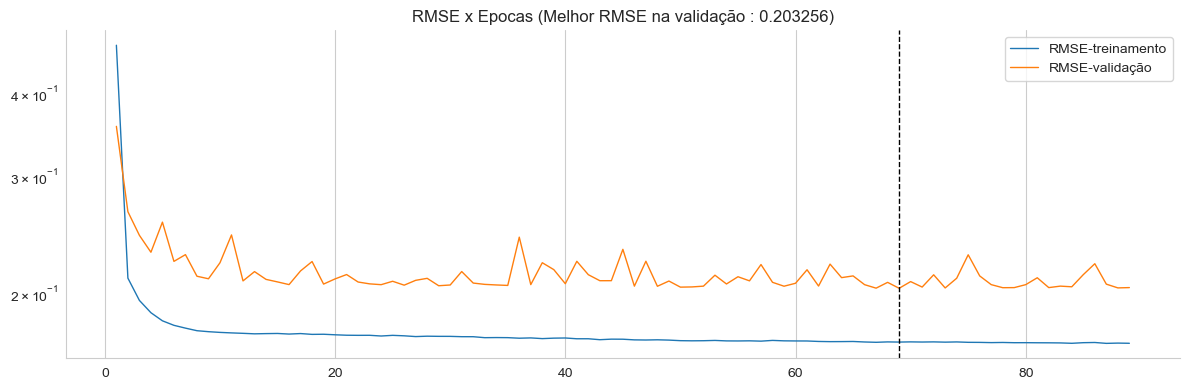

In [21]:
#===============================================================================================================================
# RESULTS - PERFORMANCE vs EPOCHS - TRAIN, VALIDATION
#===============================================================================================================================
fig, ax = plt.subplots(figsize=(12, 4))

loss_history = pd.DataFrame(lstm_training.history).pow(.5)
loss_history.index += 1
best_rmse = loss_history.val_loss.min()

best_epoch = loss_history.val_loss.idxmin()

title = f'RMSE x Epocas (Melhor RMSE na validação : {best_rmse:.6})'
loss_history.columns=['RMSE-treinamento', 'RMSE-validação']
loss_history.rolling(1).mean().plot(logy=True, lw=1, title=title, ax=ax)

ax.axvline(best_epoch, ls='--', lw=1, c='k')

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'rnn_error', dpi=300);

In [22]:
#===============================================================================================================================
# RESULTS - PERFORMANCE - TRAIN, TEST
#===============================================================================================================================
train_rmse_scaled = np.sqrt(rnn.evaluate(X_train, y_train, verbose=0))
test_rmse_scaled = np.sqrt(rnn.evaluate(X_test, y_test, verbose=0))
print(f'Train RMSE: {train_rmse_scaled:.4f} | Test RMSE: {test_rmse_scaled:.4f}')
#-------------------------------------------------------------------------------------------------------------------------------
# Train RMSE: 0.1702 | Test RMSE: 0.2027
#-------------------------------------------------------------------------------------------------------------------------------

Train RMSE: 0.1675 | Test RMSE: 0.2033


In [23]:
#===============================================================================================================================
# RESULTS - FORECAST - TRAIN, TEST
#===============================================================================================================================
train_predict_scaled = rnn.predict(X_train)
test_predict_scaled = rnn.predict(X_test)

8/8 [==============================] - 0s 4ms/step


In [24]:
#===============================================================================================================================
# RESULTS - SPEARMAN IC - TRAIN, TEST
#===============================================================================================================================
train_ic = spearmanr(y_train, train_predict_scaled)[0]
test_ic = spearmanr(y_test, test_predict_scaled)[0]
print(f'Train IC: {train_ic:.6f} | Test IC: {test_ic:.5f}')
#-------------------------------------------------------------------------------------------------------------------------------
# Train IC: 0.985757 | Test IC: 0.92917
#-------------------------------------------------------------------------------------------------------------------------------

Train IC: 0.986041 | Test IC: 0.92869


In [25]:
#===============================================================================================================================
# RESULTS - FORECAST - RESULTS
#===============================================================================================================================
np.savetxt('Data/Output/LSTM-Jansen-FracDiff-Standard-Daily-Scaled-Test.txt', test_predict_scaled, delimiter=';')
test_predict_scaled[:,0]

array([1.4923229 , 1.0597701 , 0.8400209 , 1.038153  , 1.3315437 ,
       1.4729714 , 1.4636681 , 1.6500863 , 1.826305  , 1.7059557 ,
       1.5673649 , 1.3542475 , 1.6652141 , 1.7356312 , 1.7912335 ,
       1.652441  , 1.6115247 , 1.7729688 , 1.8999887 , 1.8547893 ,
       1.5978513 , 1.6163044 , 1.764246  , 1.5691183 , 1.3339659 ,
       1.1706538 , 1.2450284 , 1.1426196 , 1.4344891 , 1.1714016 ,
       1.2086737 , 1.3147285 , 1.1911777 , 1.4250573 , 1.4576612 ,
       1.352476  , 1.1071427 , 1.2019873 , 0.99025816, 1.0176167 ,
       0.94224775, 0.9014369 , 0.7979898 , 0.8919407 , 1.0112493 ,
       0.96344364, 1.2525148 , 1.0702016 , 0.9005605 , 0.865878  ,
       0.8669594 , 0.8568073 , 0.96708375, 0.80253935, 0.6971438 ,
       0.7296746 , 0.6605498 , 0.4224727 , 0.54528004, 0.67537606,
       0.87873757, 0.9606694 , 1.1875894 , 0.95306486, 0.90775156,
       0.96296036, 0.86210626, 0.85696876, 0.9936216 , 1.5124619 ,
       1.5742972 , 1.4669648 , 1.4170146 , 1.3720559 , 1.38591

In [26]:
#===============================================================================================================================
# RESULTS - FRACDIFF - RECOVER - PRED - TRAIN, TEST
#===============================================================================================================================
train_predict = pd.Series(scaler.inverse_transform(train_predict_scaled).squeeze(), index=y_train.index)
test_predict = (pd.Series(scaler.inverse_transform(test_predict_scaled).squeeze(), index=y_test.index))

np.savetxt('Data/Output/LSTM-Jansen-FracDiff-Standard-Daily-Train.txt', train_predict, delimiter=';')
np.savetxt('Data/Output/LSTM-Jansen-FracDiff-Standard-Daily-Test.txt' , test_predict , delimiter=';')

test_predict

Date
2023-01-02    20044.148438
2023-01-03    17442.847656
2023-01-04    16121.312500
2023-01-05    17312.845703
2023-01-06    19077.248047
                  ...     
2023-12-21    27122.712891
2023-12-22    27791.054688
2023-12-26    28009.789062
2023-12-27    28300.156250
2023-12-28    28519.416016
Length: 248, dtype: float32

In [27]:
#===============================================================================================================================
# RESULTS - FRACDIFF - RECOVER - TARGET - TRAIN, TEST
#===============================================================================================================================
y_train_rescaled = scaler.inverse_transform(y_train.to_frame()).squeeze()
y_test_rescaled = scaler.inverse_transform(y_test.to_frame()).squeeze()

y_test_rescaled

array([16548.9486494 , 15112.08589238, 17095.53824067, 19463.64369831,
       20319.88163955, 20031.13724526, 21501.23903543, 22669.81694135,
       21352.19497411, 20284.32938683, 18683.76510605, 21319.17823985,
       21684.03348622, 22035.037179  , 20821.18808584, 20567.16972093,
       21900.21079595, 22810.23479997, 22268.07070387, 20221.30195775,
       20511.86752773, 21755.98977796, 20137.90481114, 18440.22553165,
       17364.46504156, 18168.84967708, 17493.7005381 , 19982.1103913 ,
       17698.0215855 , 18179.72401629, 19081.27034205, 18000.02283192,
       19996.93963377, 20010.50002777, 19070.07671467, 17163.57169673,
       18140.37409857, 16443.49608395, 16884.72650006, 16358.21769438,
       16161.28298076, 15425.15253933, 16411.99912423, 17343.78775201,
       16776.37512216, 19225.67765895, 17264.43000271, 16028.41296089,
       15962.9564427 , 16079.48107127, 16033.19066577, 16989.40112556,
       15472.59287807, 14800.63639949, 15313.13614659, 14735.1266281 ,
      

In [28]:
#===============================================================================================================================
# RESULTS - FRACDIFF - PERFORMANCE - TRAIN, TEST
#===============================================================================================================================
train_rmse = np.sqrt(mean_squared_error(train_predict, y_train_rescaled))
test_rmse = np.sqrt(mean_squared_error(test_predict, y_test_rescaled))
f'Train RMSE: {train_rmse:.2f} | Test RMSE: {test_rmse:.2f}'
#-------------------------------------------------------------------------------------------------------------------------------
# 'Train RMSE: 1023.81 | Test RMSE: 1218.98'
#-------------------------------------------------------------------------------------------------------------------------------

'Train RMSE: 1007.22 | Test RMSE: 1222.35'

In [29]:
#===============================================================================================================================
# RESULTS - FRACDIFF - STORE - TRAIN, TEST
#===============================================================================================================================
df['Train Predictions'] = train_predict
df['Test Predictions'] = test_predict

temp = pd.concat([train_predict.to_frame('predictions').assign(data='Train'), test_predict.to_frame('predictions').assign(data='Test')])
df['predictions'] = temp['predictions']
df['data']        = temp[ 'data']

df['2022-12-29':]

,Close,Train Predictions,Test Predictions,predictions,data
Date,,,,,
2022-12-29,19960.780669,20541.925781,NaN,20541.925781,Train
2023-01-02,16548.948649,NaN,20044.148438,20044.148438,Test
2023-01-03,15112.085892,NaN,17442.847656,17442.847656,Test
2023-01-04,17095.538241,NaN,16121.312500,16121.312500,Test
2023-01-05,19463.643698,NaN,17312.845703,17312.845703,Test
...,...,...,...,...,...
2023-12-21,28560.747482,NaN,27122.712891,27122.712891,Test
2023-12-22,28708.794508,NaN,27791.054688,27791.054688,Test
2023-12-26,29129.784786,NaN,28009.789062,28009.789062,Test


In [30]:
#===============================================================================================================================
# RESULTS - FRACDIFF - EXPORT
#===============================================================================================================================
df.to_excel('Data/Output/LSTM-Jansen-FracDiff-Standard-Daily.xlsx')

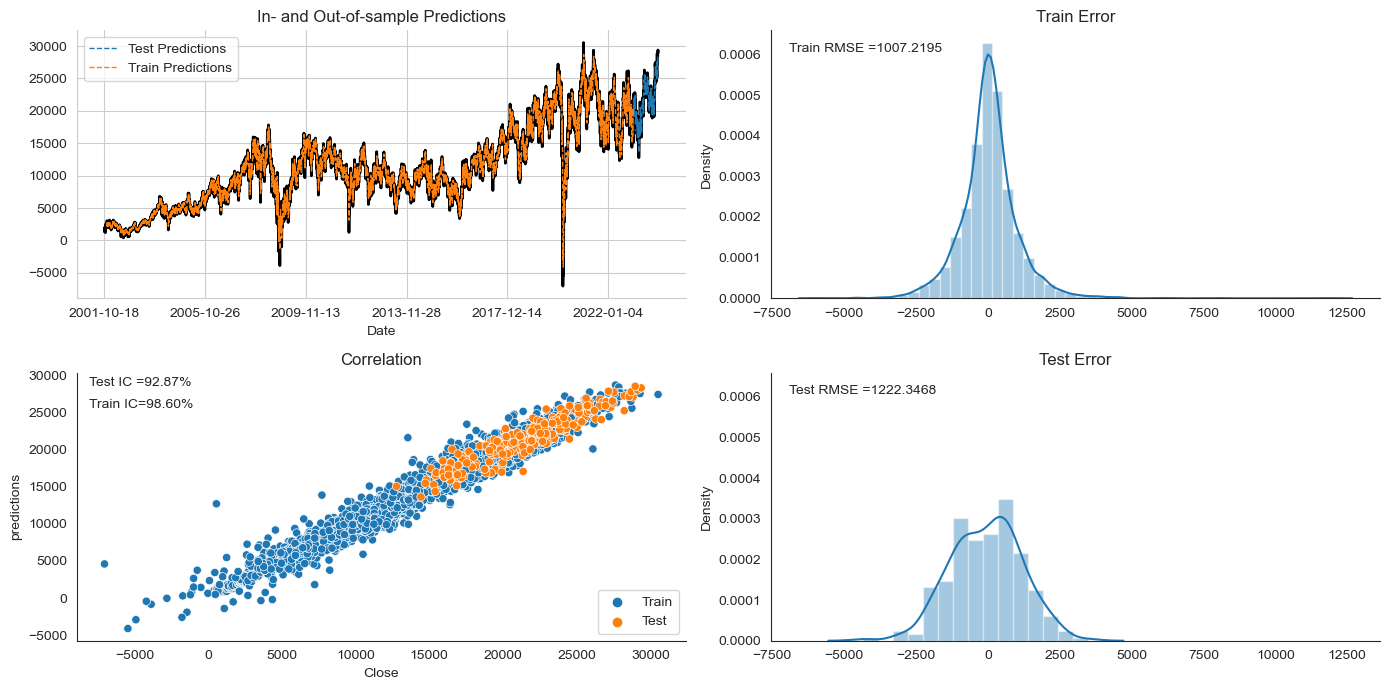

In [31]:
#===============================================================================================================================
# RESULTS - FRACDIFF - PLOT
#===============================================================================================================================
fig=plt.figure(figsize=(14,7))

ax1 = plt.subplot(221)
df.loc['2000':, 'Close'].plot(lw=2, ax=ax1, c='k')
df.loc['2000':, 'predictions'].plot(lw=1.5, ax=ax1, c='k')
df.loc['2000':, ['Test Predictions', 'Train Predictions']].plot(lw=1, ax=ax1, ls='--')
ax1.set_title('In- and Out-of-sample Predictions')

with sns.axes_style("white"):
    ax3 = plt.subplot(223)
    sns.scatterplot(x='Close', y='predictions', data=df, hue='data', ax=ax3)
    ax3.text(x=.02, y=.95, s=f'Test IC ={test_ic:.2%}', transform=ax3.transAxes)
    ax3.text(x=.02, y=.87, s=f'Train IC={train_ic:.2%}', transform=ax3.transAxes)
    ax3.set_title('Correlation')
    ax3.legend(loc='lower right')
    
    ax2 = plt.subplot(222)
    ax4 = plt.subplot(224, sharex = ax2, sharey=ax2)
    sns.distplot(train_predict.squeeze()- y_train_rescaled, ax=ax2)
    ax2.set_title('Train Error')
    ax2.text(x=.03, y=.92, s=f'Train RMSE ={train_rmse:.4f}', transform=ax2.transAxes)
    sns.distplot(test_predict.squeeze()-y_test_rescaled, ax=ax4)
    ax4.set_title('Test Error')
    ax4.text(x=.03, y=.92, s=f'Test RMSE ={test_rmse:.4f}', transform=ax4.transAxes)

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'rnn_regression', dpi=300);


In [32]:
#===============================================================================================================================
# FRACDIFF: RECOVER - PRICES - d, THRESHOLD
#===============================================================================================================================
d=0.2485
THRESHOLD=1e-4

In [33]:
#===============================================================================================================================
# FRACDIFF: RECOVER - FUNCTION WEIGHTS
#===============================================================================================================================
def getWeights_FFD(d, thres=THRESHOLD, lim=10000):
    w, k = [1.], 1                          # Set w as a list and k as one
    ctr = 0                                 # Set ctr
    while True:                             # Loop While
        w_ = -w[-1] / k * (d - k + 1)          # Create the new weight value
        if abs(w_) < thres:break               # End the loop in case the threshold is breached
        w.append(w_)                           # Append the new value of w
        k += 1                                 # Increment k
        ctr += 1                               # Increment ctr
        if ctr == lim - 1:break                # End the loop in case it breaches the limit
    return np.array(w[::-1]).reshape(-1, 1) # Convert the w from list to a numpy array

In [34]:
#===============================================================================================================================
# FRACDIFF: RECOVER - WEIGHTS
#===============================================================================================================================
#w_FFD = getWeights_FFD(d, thres=1e-6, lim=5942-446+1)
w_FFD = getWeights_FFD(d, thres=1e-6, lim=248)
print(len(w_FFD[:-1]))
w_FFD[:]

247


array([[-2.09285730e-04],
       [-2.10348971e-04],
       [-2.11421981e-04],
       [-2.12504888e-04],
       [-2.13597826e-04],
       [-2.14700930e-04],
       [-2.15814335e-04],
       [-2.16938183e-04],
       [-2.18072615e-04],
       [-2.19217776e-04],
       [-2.20373812e-04],
       [-2.21540875e-04],
       [-2.22719116e-04],
       [-2.23908690e-04],
       [-2.25109756e-04],
       [-2.26322476e-04],
       [-2.27547012e-04],
       [-2.28783533e-04],
       [-2.30032207e-04],
       [-2.31293210e-04],
       [-2.32566717e-04],
       [-2.33852908e-04],
       [-2.35151966e-04],
       [-2.36464079e-04],
       [-2.37789437e-04],
       [-2.39128233e-04],
       [-2.40480666e-04],
       [-2.41846937e-04],
       [-2.43227252e-04],
       [-2.44621820e-04],
       [-2.46030854e-04],
       [-2.47454573e-04],
       [-2.48893199e-04],
       [-2.50346958e-04],
       [-2.51816081e-04],
       [-2.53300804e-04],
       [-2.54801368e-04],
       [-2.56318018e-04],
       [-2.5

In [35]:
#===============================================================================================================================
# PREDICTION FFD: y_pred_fracdiff
#===============================================================================================================================
#y_pred_fracdiff=df.loc['2023-01-31':,'predictions'].to_frame()
y_pred_fracdiff=df['predictions'].to_frame()
y_pred_fracdiff.rename(columns={'predictions':'Residuals'}, inplace=True)
y_pred_fracdiff[-248:]


,Residuals
Date,
2023-01-02,20044.148438
2023-01-03,17442.847656
2023-01-04,16121.312500
2023-01-05,17312.845703
2023-01-06,19077.248047
...,...
2023-12-21,27122.712891
2023-12-22,27791.054688
2023-12-26,28009.789062


In [36]:
#===============================================================================================================================
# DATA: READ - PRICES - ORI
#===============================================================================================================================
seriesId = 'IBOV'
df_temp = pd.read_csv(seriesId+'.csv')

df_test_ori = df_temp.copy()
df_test_ori['Date'] = pd.to_datetime(df_test_ori['Date'], dayfirst=True)
df_test_ori = df_test_ori.loc[:, ['Date', 'Close']]
df_test_ori = df_test_ori.set_index('Date')
#df_test_ori = df_test_ori['2022-03-09':]
df_test_ori = df_test_ori['2022-01-06':]
df_test_ori

,Close
Date,
2022-01-06,101561.05
2022-01-07,102719.47
2022-01-10,101945.20
2022-01-11,103778.98
2022-01-12,105685.66
...,...
2023-12-21,132182.01
2023-12-22,132752.93
2023-12-26,133532.92


In [37]:
#===============================================================================================================================
# DATA: RECOVER - FRACDIFF - FUNCTION
#===============================================================================================================================
def fracDiff_FFD_recover(series_ffd,d,thres=THRESHOLD, w=None,series_ori=None):

    width=len(w)
    
    df= {}
    prices_ori,df_=series_ori, pd.Series() 
    
    print('width = ',width)
    print('')
    #---------------------------------------------------------------------------------------------------------------------------
    # Loop W
    #---------------------------------------------------------------------------------------------------------------------------
    for iloc1 in range(0,width):
        print('-------------------------------------------------')
        #-----------------------------------------------------------------------------------------------------------------------
        # loc0, loc1
        #-----------------------------------------------------------------------------------------------------------------------
        loc0=prices_ori.index[iloc1]
        loc1=prices_ori.index[iloc1-width-1]
        locffd0=series_ffd.index[iloc1]

        print('')
        print('Loop: iloc1=', iloc1, ' | loc0=', loc0, ' | loc1=', loc1, ' | locffd0=', locffd0)

        if not (np.isfinite(series_ori.loc[loc1])).any():continue

        print('')
        print('w[iloc1]           = ', np.round(w[iloc1],6))
        print('series_ori[loc0]   = ', series_ori.loc[loc0,'Close'])
        print('series_ori[loc1]   = ', series_ori.loc[loc1,'Close'])
        print('series_ffd[locffd0]= ', series_ffd.loc[locffd0,'Residuals'])
            
        #-----------------------------------------------------------------------------------------------------------------------
        # Dot Product w x series_ori[loc0:loc1]
        #-----------------------------------------------------------------------------------------------------------------------
        print('')
        df_[loc1]=np.dot(w[:-1].T,series_ori.loc[loc0:loc1])[0]
        print('dot(w, series_ori  = ', df_[loc1])
        df_[loc1]=np.round(series_ffd.loc[locffd0,'Residuals'] - df_[loc1],2)
        print('Pred               = ', df_[loc1])

    df['Close']=df_.copy(deep=True)
    df=pd.concat(df,axis=1)

    return df

In [38]:
#===============================================================================================================================
# FRACDIFF: RECOVER - PRICES - RUN FRACDIFF RECOVER
#===============================================================================================================================
test_predict_recover_price = fracDiff_FFD_recover(y_pred_fracdiff[-248:], d, THRESHOLD, w_FFD[:], df_test_ori)

width =  248

-------------------------------------------------

Loop: iloc1= 0  | loc0= 2022-01-06 00:00:00  | loc1= 2022-12-29 00:00:00  | locffd0= 2023-01-02

w[iloc1]           =  [-0.000209]
series_ori[loc0]   =  101561.05
series_ori[loc1]   =  109734.6
series_ffd[locffd0]=  20044.148

dot(w, series_ori  =  [-86562.71579901]
Pred               =  106606.86
-------------------------------------------------

Loop: iloc1= 1  | loc0= 2022-01-07 00:00:00  | loc1= 2023-01-02 00:00:00  | locffd0= 2023-01-03

w[iloc1]           =  [-0.00021]
series_ori[loc0]   =  102719.47
series_ori[loc1]   =  106376.02
series_ffd[locffd0]=  17442.848

dot(w, series_ori  =  [-85792.10248939]
Pred               =  103234.95
-------------------------------------------------

Loop: iloc1= 2  | loc0= 2022-01-10 00:00:00  | loc1= 2023-01-03 00:00:00  | locffd0= 2023-01-04

w[iloc1]           =  [-0.000211]
series_ori[loc0]   =  101945.2
series_ori[loc1]   =  104165.74
series_ffd[locffd0]=  16121.3125

dot(w, 

dot(w, series_ori  =  [-86526.82708647]
Pred               =  104865.16
-------------------------------------------------

Loop: iloc1= 31  | loc0= 2022-02-18 00:00:00  | loc1= 2023-02-13 00:00:00  | locffd0= 2023-02-14

w[iloc1]           =  [-0.000247]
series_ori[loc0]   =  112879.85
series_ori[loc1]   =  108836.47
series_ffd[locffd0]=  18976.125

dot(w, series_ori  =  [-86620.75363736]
Pred               =  105596.88
-------------------------------------------------

Loop: iloc1= 32  | loc0= 2022-02-21 00:00:00  | loc1= 2023-02-14 00:00:00  | locffd0= 2023-02-15

w[iloc1]           =  [-0.000249]
series_ori[loc0]   =  111725.3
series_ori[loc1]   =  107848.81
series_ffd[locffd0]=  18233.111

dot(w, series_ori  =  [-86375.8258526]
Pred               =  104608.94
-------------------------------------------------

Loop: iloc1= 33  | loc0= 2022-02-22 00:00:00  | loc1= 2023-02-15 00:00:00  | locffd0= 2023-02-16

w[iloc1]           =  [-0.00025]
series_ori[loc0]   =  112891.8
series_ori[lo

dot(w, series_ori  =  [-82061.07002396]
Pred               =  99021.75
-------------------------------------------------

Loop: iloc1= 85  | loc0= 2022-05-11 00:00:00  | loc1= 2023-05-05 00:00:00  | locffd0= 2023-05-08

w[iloc1]           =  [-0.000354]
series_ori[loc0]   =  104396.9
series_ori[loc1]   =  105148.48
series_ffd[locffd0]=  19164.4

dot(w, series_ori  =  [-82752.88450752]
Pred               =  101917.28
-------------------------------------------------

Loop: iloc1= 86  | loc0= 2022-05-12 00:00:00  | loc1= 2023-05-08 00:00:00  | locffd0= 2023-05-09

w[iloc1]           =  [-0.000357]
series_ori[loc0]   =  105687.64
series_ori[loc1]   =  106042.15
series_ffd[locffd0]=  19725.059

dot(w, series_ori  =  [-83210.08788302]
Pred               =  102935.15
-------------------------------------------------

Loop: iloc1= 87  | loc0= 2022-05-13 00:00:00  | loc1= 2023-05-09 00:00:00  | locffd0= 2023-05-10

w[iloc1]           =  [-0.00036]
series_ori[loc0]   =  106924.18
series_ori[loc

dot(w, series_ori  =  [-91892.62018389]
Pred               =  114610.75
-------------------------------------------------

Loop: iloc1= 132  | loc0= 2022-07-18 00:00:00  | loc1= 2023-07-12 00:00:00  | locffd0= 2023-07-13

w[iloc1]           =  [-0.000544]
series_ori[loc0]   =  96916.13
series_ori[loc1]   =  117666.49
series_ffd[locffd0]=  22828.695

dot(w, series_ori  =  [-91888.20773825]
Pred               =  114716.9
-------------------------------------------------

Loop: iloc1= 133  | loc0= 2022-07-19 00:00:00  | loc1= 2023-07-13 00:00:00  | locffd0= 2023-07-14

w[iloc1]           =  [-0.00055]
series_ori[loc0]   =  98244.8
series_ori[loc1]   =  119263.89
series_ffd[locffd0]=  23952.227

dot(w, series_ori  =  [-92288.40616656]
Pred               =  116240.63
-------------------------------------------------

Loop: iloc1= 134  | loc0= 2022-07-20 00:00:00  | loc1= 2023-07-14 00:00:00  | locffd0= 2023-07-17

w[iloc1]           =  [-0.000556]
series_ori[loc0]   =  98286.83
series_ori[l

dot(w, series_ori  =  [-90705.8206273]
Pred               =  111102.27
-------------------------------------------------

Loop: iloc1= 194  | loc0= 2022-10-14 00:00:00  | loc1= 2023-10-09 00:00:00  | locffd0= 2023-10-10

w[iloc1]           =  [-0.001433]
series_ori[loc0]   =  112072.34
series_ori[loc1]   =  115156.07
series_ffd[locffd0]=  21102.158

dot(w, series_ori  =  [-90951.76843356]
Pred               =  112053.93
-------------------------------------------------

Loop: iloc1= 195  | loc0= 2022-10-17 00:00:00  | loc1= 2023-10-10 00:00:00  | locffd0= 2023-10-11

w[iloc1]           =  [-0.001468]
series_ori[loc0]   =  113623.98
series_ori[loc1]   =  116736.95
series_ffd[locffd0]=  22173.965

dot(w, series_ori  =  [-91421.03992825]
Pred               =  113595.0
-------------------------------------------------

Loop: iloc1= 196  | loc0= 2022-10-18 00:00:00  | loc1= 2023-10-11 00:00:00  | locffd0= 2023-10-13

w[iloc1]           =  [-0.001504]
series_ori[loc0]   =  115743.07
series_o

dot(w, series_ori  =  [-98037.87394097]
Pred               =  124942.13
-------------------------------------------------

Loop: iloc1= 231  | loc0= 2022-12-08 00:00:00  | loc1= 2023-12-04 00:00:00  | locffd0= 2023-12-05

w[iloc1]           =  [-0.006437]
series_ori[loc0]   =  107249.04
series_ori[loc1]   =  126802.79
series_ffd[locffd0]=  25872.01

dot(w, series_ori  =  [-97918.6177593]
Pred               =  123790.63
-------------------------------------------------

Loop: iloc1= 232  | loc0= 2022-12-09 00:00:00  | loc1= 2023-12-05 00:00:00  | locffd0= 2023-12-06

w[iloc1]           =  [-0.006982]
series_ori[loc0]   =  107519.56
series_ori[loc1]   =  126903.25
series_ffd[locffd0]=  25866.814

dot(w, series_ori  =  [-97979.55517696]
Pred               =  123846.37
-------------------------------------------------

Loop: iloc1= 233  | loc0= 2022-12-12 00:00:00  | loc1= 2023-12-06 00:00:00  | locffd0= 2023-12-07

w[iloc1]           =  [-0.007616]
series_ori[loc0]   =  105343.33
series_o

In [39]:
#===============================================================================================================================
# PRICES: RECOVER - PRED
#===============================================================================================================================
test_predict_recover_price

,Close
2022-12-29,106606.86
2023-01-02,103234.95
2023-01-03,101101.11
2023-01-04,102233.8
2023-01-05,104466.24
...,...
2023-12-20,127638.63
2023-12-21,128730.23
2023-12-22,129308.21
2023-12-26,130005.62


In [40]:
#===============================================================================================================================
# PRICES: READ - CLOSE
#===============================================================================================================================
dfPrices = pd.read_csv('IBOV.csv')
dfPrices['Date'] = pd.to_datetime(dfPrices['Date'], dayfirst=True)
dfPrices.set_index('Date', inplace=True)

dfPricesTest = dfPrices.loc['2023-01-01':,'Close'].to_frame()
dfPricesTest

,Close
Date,
2023-01-02,106376.02
2023-01-03,104165.74
2023-01-04,105334.46
2023-01-05,107641.32
2023-01-06,108963.70
...,...
2023-12-21,132182.01
2023-12-22,132752.93
2023-12-26,133532.92


In [41]:
#===============================================================================================================================
# PRICES: PERFORMANCE - PRICE
#===============================================================================================================================
#train_rmse = np.sqrt(mean_squared_error(train_predict, y_train_rescaled))
test_rmse = np.sqrt(mean_squared_error(dfPricesTest, test_predict_recover_price))
#print(f'Train RMSE: {train_rmse:.2f} | Test RMSE: {test_rmse:.2f}')
print(f'Test RMSE: {test_rmse:.2f}')
#-------------------------------------------------------------------------------------------------------------------------------
# Test RMSE: 3428.41
#-------------------------------------------------------------------------------------------------------------------------------

Test RMSE: 3413.73
